# IST 664 Final Project - SPAM Classification
## Date: March 24, 2020
### Author: Thomas Bahng

### Public GitHub repository
* [https://github.com/tbahng/ist664-NLP-and-Classification](https://github.com/tbahng/ist664-NLP-and-Classification)

# Introduction
SPAM filtering is a commonplace task for most email applications. For the user it saves time and clutter, and mitigates the risk of harm. SPAM emails may contain viruses, phishing schemes, and other embarassing content that is not safe for work. This an especially important task in an age where hacking and information security are large concerns for companies and individuals.

Some applications like Microsoft Outlook or Google Mail let the user define SPAM emails to look out for. "Mail filters have varying degrees of configurability. Sometimes they make decisions based on matching a regular expression. Other times, code may match keywords in the message body, or perhaps the email address of the sender of the message...Some more advanced filters, particularly anti-spam filters, use statistical document classification techniques such as the naive Bayes classifier." [https://en.wikipedia.org/wiki/Email_filtering](https://en.wikipedia.org/wiki/Email_filtering)

The objective of this project is to demonstrate classification of SPAM in a repository of emails using NLP techniques and toolkits. It will include an exploration of emails and multiple experiments that compare feature sets to determine which combination makes for the best SPAM detection application. Each experiment will rely on pre-processing, feature engineering and classification modeling specific to the scenario.

In addition to this report, a Python program file "classifySPAM.py" includes the relevant processing steps to reproduce results and is packaged together as part of the deliverable. ***Special acknowledgement goes to instructor Nancy McCraken in providing baseline code for "classifySPAM.py" and data.***

# Analysis
The following steps outline the process of analysis:
* About the Data
* Exploration
    * Corpus Statistics
    * Visualizations
    * Frequency Distributions
* Modeling Experiments
    * Feature Engineering
    * Classifiers

In [1]:
import os
import pandas as pd 
import numpy as np 
import nltk
from nltk import FreqDist, word_tokenize, bigrams
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder, TrigramAssocMeasures, TrigramCollocationFinder
from nltk.corpus import PlaintextCorpusReader, stopwords
from nltk.text import Text 
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
sns.set(style = 'white')
sns.set(style = 'whitegrid', color_codes = True)
import random
import re

## About the Data
The original data is available from [http://www2.aueb.gr/users/ion/data/enron-spam/](http://www.aueb.gr/users/ion/data/enron-spam/).

Curated data was provided for detecting Spam emails from the Enron public email corpus. The non-Spam emails are labeled “ham”. (See [this paper](http://www.aueb.gr/users/ion/docs/ceas2006_paper.pdf) for details) 

In addition to some small numbers of Spam already in the corpus, additional spam emails were introduced into each user’s email stream in order to have a sufficient number of spam examples to train a classifier. The repository of data consists of 3,672 regular emails in the “ham” folder, and 1,500 emails in the “spam” folder.

The following directory structure is recommended to support this notebook and the relevant program:
* Project Files
    * thomas_bahng_final.ipynb + classifySPAM.py
        * corpus
            * ham 
            * spam 

### Extract both SPAM and HAM emails from text files

In [2]:
spamDir = 'corpus/spam' # directory of SPAM emails
hamDir = 'corpus/ham' # directory of HAM emails

In [3]:
# function to get absolute filepaths in a directory
# param directory: absolute directory name
# yields absolute file paths
def absoluteFilePaths(directory):
   for dirpath,_,filenames in os.walk(directory):
       for f in filenames:
           yield os.path.abspath(os.path.join(dirpath, f))

# function to do baseline processing of emails from a directory into a list of tokenized documents
# param directory: absolute directory name
# param label: either 'spam' or 'ham'
# returns texts and documents
def process(directory, label):    
    texts = [] # initialize list of strings where each string is an email
    # get list of absolute file paths in directory
    myGenerator = absoluteFilePaths(directory)
    filelist = []
    for f in myGenerator:
        filelist.append(f)
    # process all files in directory that end in .txt
    for f in filelist:
        if (f.endswith(".txt")):
            # open file for reading and read entire file into a string            
            with open(f, 'r', encoding = 'latin-1') as fin:
                texts.append(fin.read())
    documents = [] # initialize list of tuples where each element is a tokenized email with its label
    # process each email
    for text in texts:
        tokens = word_tokenize(text)
        documents.append((tokens, label))
    return texts, documents

# function to compute basic corpus statistics for either spam or ham
# param texts: a list of strings where each element is email text
# param documents: a list of tuples where the first item of each tuple is the tokenized email text
# prints corpus statistics
def getstats(texts, documents):
    text_list = [text for text in texts]
    doc_list = [doc[0] for doc in documents]
    print("Email level statistics:\n")
    # average number of characters per email
    avg_chars = int(sum([len(t) for t in text_list]) / len(text_list))
    print("Average number of characters per email: {:d}".format(avg_chars))
    # average number of words per email
    avg_words = int(sum([len(doc) for doc in doc_list]) / len(doc_list))
    print("Average number of words per email: {:d}".format(avg_words))
    # average vocabulary size per email
    avg_vocab = int(sum([len(set(doc)) for doc in doc_list]) / len(doc_list))
    print("Average vocabulary size per email: {:d}".format(avg_vocab))
    # average lexical richness per email (proportion of unique words to total words)
    avg_lex_rich = sum([len(set(doc))/len(doc) for doc in doc_list]) / len(doc_list)
    print("Average lexical richness per email: {:.2f}".format(avg_lex_rich))
    print("\nCorpus level statistics:\n")
    words = []
    for doc in doc_list:
        words.extend(doc)
    # total number of words
    print("Total number of words: {:d}".format(len(words)))
    # vocabulary size
    print("Total vocabulary size: {:d}".format(len(set(words))))
    # lexical richness
    print("Total lexical richness: {:.2f}".format(len(set(words)) / len(words)))
    # average number of characters per word
    word_lengths = [len(w) for w in words]
    print("Average number of characters per word: {:.2f}".format(sum(word_lengths) / len(word_lengths)))    

# function to extract tokens from documents
# param documents: a list of tuples where the first item of each tuple is the tokenized email text
# returns a single list of all tokens from email documents
def getTokens(documents):
    tokens = []
    for doc in documents:
        for w in doc[0]:
            tokens.append(w)
    return tokens

# function to print top n bigram frequency distribution
# param documents: a list of tuples where the first item of each tuple is the tokenized email text
# param type: 'freq' (frequency) or 'mi' (mutual information)
# param n: top n parameter for bigrams to print
# prints results
# returns scored bigrams
def getBigramDist(documents, n, type = 'freq'):
    tokens = [w.lower() for w in getTokens(documents)]
    measures = BigramAssocMeasures()
    finder = BigramCollocationFinder.from_words(tokens) # scorer
    finder.apply_word_filter(alpha_filter) # exclude non-alphabetic words
    finder.apply_word_filter(lambda w: w in stopwords) # exclude stop words
    if type == 'mi':
        finder.apply_freq_filter(5) # frequency filter of greater than or equal to 5
        scored = finder.score_ngrams(measures.pmi) # distribution of mutual information
        print("Top 100 most common strongly connected bigrams out of total {:d} unique bigrams:\n".format(len(scored)))
    else:
        # distribution of frequency as proportion of the bigram count to count of all bigrams
        scored = finder.score_ngrams(measures.raw_freq)
        print("Top 100 most common bigrams out of total {:d} unique bigrams:\n".format(len(scored)))
    print([score[0] for score in scored[:n]])
    return scored

# define stopwords
from nltk.corpus import stopwords
stopwords1 = stopwords.words('english')

# function that identifies non-alphabetic tokens
# param w: string word
# returns true if word consists only of non-alphabetic characters 
def alpha_filter(w):
    # pattern to match a word of non-alphabetical characters
    pattern = re.compile('^[^a-z]+$')
    if pattern.match(w):
        return True
    else:
        return False

# function to clean a list of tokens [basic]
# param tokens: a list of strings where each element is a token
# returns a new list of cleaned tokens
def clean1(tokens):
    # convert tokens to lower-case
    tokens = [w.lower() for w in tokens]
    # remove non-alphabetic words
    tokens = [w for w in tokens if not alpha_filter(w)]    
    # remove stop words
    tokens = [w for w in tokens if not w in stopwords1]
    return tokens  

In [4]:
%%time
spamTexts, spamDocs = process(spamDir, 'spam')
hamTexts, hamDocs = process(hamDir, 'ham')
print("Total number of SPAM documents read: {:d}".format(len(spamDocs)))
print("Total number of HAM documents read: {:d}".format(len(hamDocs)))

Total number of SPAM documents read: 1500
Total number of HAM documents read: 3672
Wall time: 10.3 s


*The proportion of SPAM to HAM emails is 0.41, or 41%. This is less than half the size of the HAM repository.*

# Exploration
* Corpus Statistics
* Visualizations

## SPAM Corpus Statistics

In [5]:
getstats(spamTexts, spamDocs)

Email level statistics:

Average number of characters per email: 1203
Average number of words per email: 236
Average vocabulary size per email: 123
Average lexical richness per email: 0.70

Corpus level statistics:

Total number of words: 355375
Total vocabulary size: 38799
Total lexical richness: 0.11
Average number of characters per word: 4.09


## HAM Corpus Statistics

In [6]:
getstats(hamTexts, hamDocs)

Email level statistics:

Average number of characters per email: 959
Average number of words per email: 226
Average vocabulary size per email: 90
Average lexical richness per email: 0.57

Corpus level statistics:

Total number of words: 830750
Total vocabulary size: 20249
Total lexical richness: 0.02
Average number of characters per word: 3.25


Observations:
* *On a per email basis, SPAM emails are generally longer than HAM emails and contain more unique words.*
* *SPAM emails measure higher in lexical richness than HAM emails*

Actions:
* *Add features measuring document statistics for modeling as these seem to distinguish SPAM and HAM.*

### Examine the Text in SPAM: First 50 tokens

In [7]:
# inspect first 50 tokens
print(getTokens(spamDocs)[:50])    

['Subject', ':', 'dobmeos', 'with', 'hgh', 'my', 'energy', 'level', 'has', 'gone', 'up', '!', 'stukm', 'introducing', 'doctor', '-', 'formulated', 'hgh', 'human', 'growth', 'hormone', '-', 'also', 'called', 'hgh', 'is', 'referred', 'to', 'in', 'medical', 'science', 'as', 'the', 'master', 'hormone', '.', 'it', 'is', 'very', 'plentiful', 'when', 'we', 'are', 'young', ',', 'but', 'near', 'the', 'age', 'of']


### Examine the Text in HAM: First 50 tokens

In [8]:
# inspect first 50 tokens
print(getTokens(hamDocs)[:50])    

['Subject', ':', 'christmas', 'tree', 'farm', 'pictures', 'Subject', ':', 'vastar', 'resources', ',', 'inc', '.', 'gary', ',', 'production', 'from', 'the', 'high', 'island', 'larger', 'block', 'a', '-', '1', '#', '2', 'commenced', 'on', 'saturday', 'at', '2', ':', '00', 'p', '.', 'm', '.', 'at', 'about', '6', ',', '500', 'gross', '.', 'carlos', 'expects', 'between', '9', ',']


*Upon examination, it is clear that both categories could mutually benefit from applying some basic cleaning transformations.*

Observations:
* *There are non-alphabetic words in the basic tokenization*
* *Tokens are case-sensitive, which for the purposes of SPAM detection may not be a necessity*
* *The word 'Subject' is commonplace and may not be useful for distinguishing SPAM/HAM*

Actions:
* *Remove non-alphabetic words*
* *Convert tokens to lower-case*
* *Define and add to Stopwords list words that are highly commonplace such as: 'the'*

### Apply basic cleaning process to tokens and inspect frequency distributions

In [9]:
# do an basic cleaning of the original spam and ham tokens
spamTokens = clean1(getTokens(spamDocs))
hamTokens = clean1(getTokens(hamDocs))

In [10]:
print("There are {:d} SPAM tokens".format(len(spamTokens)))
print("There are {:d} HAM tokens".format(len(hamTokens)))

There are 179807 SPAM tokens
There are 323901 HAM tokens


## Top 50 words by frequency - SPAM

In [11]:
fdistspam = FreqDist(spamTokens) # frequency distribution
print([item for item in fdistspam.most_common(50)])

[('subject', 1658), ('com', 993), ('http', 983), ('company', 731), ('e', 638), ('www', 587), ('information', 520), ('font', 515), ('td', 504), ('get', 486), ('please', 485), ('statements', 476), ('email', 475), ('us', 471), ('price', 471), ('new', 434), ('may', 423), ('nbsp', 418), ('one', 392), ('p', 391), ('height', 362), ('time', 361), ('free', 314), ('within', 313), ('pills', 311), ('r', 306), ('size', 306), ('width', 306), ('stock', 299), ('b', 298), ('message', 297), ('money', 295), ('investment', 290), ('c', 283), ('u', 283), ('report', 282), ('inc', 268), ('securities', 263), ('business', 258), ('online', 257), ('click', 256), ('looking', 254), ('best', 254), ('mail', 245), ('contact', 243), ('like', 243), ('computron', 242), ('prices', 239), ('align', 233), ('future', 232)]


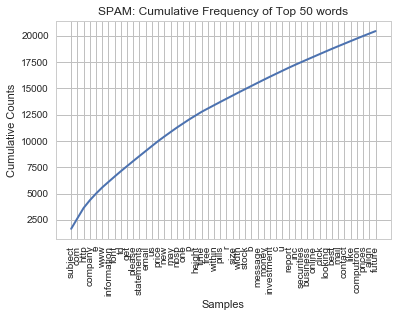

In [12]:
fdistspam.plot(50, cumulative = True, title = "SPAM: Cumulative Frequency of Top 50 words")

## Top 50 words by frequency - HAM

In [13]:
fdistham = FreqDist(hamTokens) # frequency distribution
print([item for item in fdistham.most_common(50)])

[('ect', 13897), ('hou', 7281), ('enron', 6555), ('subject', 6403), ('gas', 2861), ('deal', 2789), ('com', 2717), ('please', 2715), ('meter', 2459), ('cc', 2359), ('pm', 2325), ('hpl', 2318), ('daren', 1901), ('thanks', 1813), ('corp', 1710), ('know', 1438), ('mmbtu', 1349), ('e', 1338), ('j', 1300), ('forwarded', 1296), ('need', 1257), ('farmer', 1137), ('let', 1086), ('attached', 1083), ('xls', 1020), ('see', 1018), ('new', 1003), ('may', 960), ('l', 923), ('contract', 883), ('volume', 877), ('would', 875), ('robert', 875), ('day', 874), ('sitara', 861), ('nom', 831), ('texas', 796), ('get', 790), ('volumes', 790), ('month', 780), ('questions', 760), ('pec', 752), ('deals', 745), ('price', 735), ('ena', 732), ('bob', 706), ('th', 706), ('flow', 673), ('message', 669), ('energy', 664)]


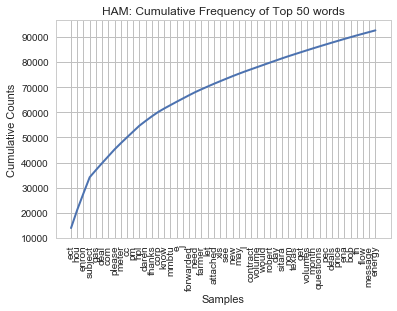

In [14]:
fdistham.plot(50, cumulative = True, title = "HAM: Cumulative Frequency of Top 50 words")

*Upon examination of the unigram frequency distributions for both SPAM and HAM, it is clear that the top 50 words for HAM make up a greater proportion of its total word frequency relative to SPAM. This was expected as SPAM exhibited to have a more extensive vocabulary in previous corpus statistics.*

Observations:
*Distinguishing features observed for SPAM includes words like ('http', 'www'). The top 50 frequency lexicon for SPAM appears quite distinct from HAM.*
*Distinguishing features observed for HAM includes words like 'ect' (Enron Capital and Trade) and other corporate references.*

Actions:
* *Identify more high frequency words that are common to both SPAM and HAM*

### Measure the Overlap of High Frequency Words Between SPAM and HAM

In [15]:
print("Top N Proportion of Word Overlap:\n")
top_n_list = [50, 100, 500, 1000, 2000, 3000]
for n in top_n_list:
    print(n, len(set([t[0] for t in fdistham.most_common(n)]) & set([t[0] for t in fdistspam.most_common(n)])) / n)    

Top N Proportion of Word Overlap:

50 0.18
100 0.27
500 0.374
1000 0.397
2000 0.4265
3000 0.44966666666666666


### Sample of Common Words between SPAM and HAM

In [16]:
n = 100
high_freq_common = list(set([t[0] for t in fdistham.most_common(n)]) & set([t[0] for t in fdistspam.most_common(n)]))
print("There are {:d} highly frequent words that are common to both SPAM and HAM:\n".format(len(high_freq_common)))
print(high_freq_common)

There are 27 highly frequent words that are common to both SPAM and HAM:

['would', 'need', 'get', 'company', 'message', 'net', 'like', 'com', 'p', 'x', 'see', 'gas', 'new', 'could', 'e', 'price', 'th', 'one', 'subject', 'also', 'l', 'us', 'please', 'may', 'mail', 'time', 'information']


### Sample of Least Common Words in SPAM and HAM

In [17]:
print("Sample of the least common words in SPAM:\n")
print(fdistspam.hapaxes()[:50])
print("\nThere are {:d} hapaxes in the SPAM text".format(len(fdistspam.hapaxes())))

Sample of the least common words in SPAM:

['dobmeos', 'stukm', 'plentiful', 'deficient', 'diminished', 'quickens', 'disappearance', 'thickness', 'texture', 'alertness', 'resistance', 'illness', 'strengthened', 'swings', 'oxwq', 'ogrg', 'lqlokeolnq', 'lnu', 'nowthe', 'involves', 'monies', 'consummating', 'tactically', 'favourably', 'favorably', 'disposed', 'obligationin', 'technicalities', 'explicitly', 'conceived', 'purposefully', 'arousing', 'forestall', 'personality', 'inks', 'famed', 'baldacci', 'simulutors', 'renews', 'motorsports', 'extension', 'opry', 'mills', 'superspeedway', 'chapin', 'venues', 'simulator', 'racers', 'nadeau', 'thumbs']

There are 21258 hapaxes in the SPAM text


In [18]:
print("Sample of the least common words in HAM:\n")
print(fdistham.hapaxes()[:50])
print("\nThere are {:d} hapaxes in the HAM text".format(len(fdistham.hapaxes())))

Sample of the least common words in HAM:

['erroneously', 'advises', 'mscf', 'ftp', 'strangas', 'rohan', 'dunns', 'transalta', 'rennie', 'accomodates', 'divert', 'omission', 'gpm', 'sliding', 'bryson', 'jeter', 'picks', 'tgt', 'limiting', 'dbas', 'mod', 'sched', 'personell', 'overs', 'unders', 'chryal', 'discrecpancy', 'hortense', 'drushell', 'anthing', 'lehrer', 'maxey', 'ocurring', 'hhere', 'sourced', 'remembers', 'indices', 'lichentwalter', 'spekels', 'moseman', 'markey', 'mosey', 'svehla', 'surprised', 'britten', 'avail', 'rarely', 'shippling', 'hymel', 'mcfaddin']

There are 6591 hapaxes in the HAM text


Observations:
* *The top 50 - 100 words for SPAM and HAM seem to be mutually exclusive for the most part. However, just the top 50-100 words may be insufficient in classifying SPAM emails due to its large vocabulary, and unigram features for classification will likely need to be substantially extended*
* *There are 26 highly frequent words that are common to both SPAM and HAM. For the purposes of this analysis, it might be beneficial to remove these words by adding them to the Stopwords list.*
* *SPAM emails contain almost four times as many hapaxes (very uncommon words) compared to HAM emails. For the purposes of this analysis, it might be beneficial to remove the hapaxes by adding them to the Stopwords list.*

Actions:
* *Define and add to Stopwords list: 'message', 'x', 'please', 'mail', 'could', 'like', 'us', 'gas', 'price', 'may', 'time', 'get', 'see', 'net', 'need', 'would', 'l', 'information', 'th', 'company', 'p', 'new', 'e', 'one', 'also', 'com'*
* *These are high frequency words that are common to both SPAM and HAM; therefore these words will be added to Stopwords.*

In [19]:
# extensive stopwords - includes high frequency words common to both labels and hapaxes (highly infrequent words)
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
addtlstopwords = ['subject'] + high_freq_common + fdistspam.hapaxes() + fdistham.hapaxes()
stopwords2 = stopwords + addtlstopwords
print("There are a total of {:d} stopwords defined".format(len(stopwords2)))

# function to clean a list of tokens [advanced]
# param tokens: a list of strings where each element is a token
# returns a new list of cleaned tokens
def clean2(tokens):
    # convert tokens to lower-case
    tokens = [w.lower() for w in tokens]
    # remove non-alphabetic words
    tokens = [w for w in tokens if not alpha_filter(w)]    
    # remove stop words
    tokens = [w for w in tokens if not w in stopwords2]
    return tokens

There are a total of 28056 stopwords defined


## Top 100 Bigrams by Frequency - SPAM

In [20]:
%%time
bigramSpamFreq = getBigramDist(spamDocs, n = 100, type = 'freq')

Top 100 most common bigrams out of total 59639 unique bigrams:

[('looking', 'statements'), ('td', 'td'), ('investment', 'advice'), ('tr', 'td'), ('forward', 'looking'), ('windows', 'xp'), ('duty', 'free'), ('ali', 'duty'), ('td', 'width'), ('information', 'provided'), ('xp', 'professional'), ('tr', 'tr'), ('soft', 'tabs'), ('jpg', 'width'), ('p', 'align'), ('securities', 'act'), ('best', 'regards'), ('without', 'notice'), ('would', 'like'), ('adobe', 'photoshop'), ('money', 'back'), ('third', 'party'), ('united', 'states'), ('jebel', 'ali'), ('microsoft', 'office'), ('current', 'price'), ('office', 'xp'), ('gif', 'width'), ('font', 'color'), ('statements', 'within'), ('font', 'face'), ('ooking', 'statements'), ('retail', 'price'), ('special', 'offers'), ('email', 'address'), ('contact', 'information'), ('could', 'cause'), ('inherent', 'conflict'), ('past', 'performance'), ('please', 'reply'), ('com', 'subject'), ('differ', 'materially'), ('information', 'remove'), ('please', 'send'), 

## Top 100 Bigrams by Frequency - HAM

In [21]:
%%time 
bigramHamFreq = getBigramDist(hamDocs, n = 100, type = 'freq')

Top 100 most common bigrams out of total 35888 unique bigrams:

[('ect', 'cc'), ('daren', 'j'), ('j', 'farmer'), ('ect', 'subject'), ('see', 'attached'), ('attached', 'file'), ('xls', 'subject'), ('please', 'let'), ('original', 'message'), ('teco', 'tap'), ('enron', 'cc'), ('enron', 'subject'), ('gas', 'daily'), ('north', 'america'), ('tenaska', 'iv'), ('enron', 'north'), ('robert', 'cotten'), ('vance', 'l'), ('l', 'taylor'), ('pat', 'clynes'), ('robert', 'e'), ('ami', 'chokshi'), ('e', 'lloyd'), ('america', 'corp'), ('melissa', 'graves'), ('hpl', 'nom'), ('aimee', 'lannou'), ('please', 'call'), ('texas', 'utilities'), ('julie', 'meyers'), ('would', 'like'), ('com', 'cc'), ('jackie', 'young'), ('hpl', 'actuals'), ('natural', 'gas'), ('deal', 'ticket'), ('george', 'weissman'), ('b', 'camp'), ('howard', 'b'), ('hpl', 'iferc'), ('susan', 'smith'), ('ls', 'hpl'), ('rita', 'wynne'), ('gas', 'nomination'), ('cotton', 'valley'), ('fuels', 'cotton'), ('hpl', 'gas'), ('com', 'subject'), ('hsc',

## Top 100 Bigrams by Mutual Information - SPAM

In [22]:
%%time 
bigramSpamMI = getBigramDist(spamDocs, n = 100, type = 'mi')

Top 100 most common strongly connected bigrams out of total 1749 unique bigrams:

[('pompeu', 'fabra'), ('universitat', 'pompeu'), ('yasser', 'arafat'), ('aftermath', 'showed'), ('bingoline', 'lotteria'), ('encarta', 'encyclopedia'), ('encyclopedia', 'delux'), ('lightly', 'injured'), ('representaciones', 'gorbea'), ('bupropion', 'hcl'), ('butalbital', 'apap'), ('khan', 'yunis'), ('lling', 'lisst'), ('remained', 'beneath'), ('spokesman', 'raanan'), ('severely', 'wounded'), ('ects', 'tras'), ('ppin', 'hin'), ('cllick', 'heree'), ('pfizer', 'viiagrra'), ('tier', 'carriers'), ('tim', 'ger'), ('appr', 'oval'), ('burns', 'calorized'), ('leaden', 'madras'), ('madras', 'meson'), ('meson', 'mitosis'), ('mitosis', 'quadrant'), ('pamphlet', 'distributed'), ('relaxation', 'leaden'), ('settlements', 'nearby'), ('spe', 'ume'), ('tri', 'cyclen'), ('italian', 'crafted'), ('soldier', 'remained'), ('congratulatory', 'salaam'), ('fatah', 'hawks'), ('firing', 'mortar'), ('kno', 'nds'), ('palestinians', 'f

## Top 100 Bigrams by Mutual Information - HAM

In [23]:
%%time 
bigramHamMI = getBigramDist(hamDocs, n = 100, type = 'mi')

Top 100 most common strongly connected bigrams out of total 3121 unique bigrams:

[('dobbin', 'huffsmith'), ('kimat', 'singla'), ('kori', 'loibl'), ('inja', 'chun'), ('los', 'angeles'), ('rare', 'instances'), ('chyral', 'hankins'), ('delma', 'salazar'), ('cecilia', 'olvera'), ('janie', 'aguayo'), ('maritta', 'mullet'), ('triple', 'lutz'), ('airport', 'pairs'), ('amanda', 'huble'), ('faith', 'killen'), ('veronica', 'espinoza'), ('brant', 'reves'), ('hyatt', 'regency'), ('marilyn', 'colbert'), ('abacus', 'technologies'), ('georgeanne', 'hodges'), ('torrey', 'moorer'), ('huge', 'favor'), ('deboisblanc', 'denny'), ('lamay', 'gaslift'), ('alfonso', 'trabulsi'), ('larrissa', 'sharma'), ('wilma', 'easter'), ('dutch', 'quigley'), ('gasper', 'rice'), ('saudi', 'arabia'), ('chantelle', 'villanueva'), ('kerry', 'roper'), ('janice', 'berke'), ('loring', 'lane'), ('imelda', 'frayre'), ('spec', 'prov'), ('karie', 'hastings'), ('lal', 'echterhoff'), ('hoff', 'heller'), ('hisd', 'schools'), ('pamela',

### Typical Frequency Scores for SPAM and HAM bigrams
* Distributional statistics computed using mean and median bigram scores

In [24]:
mean_score_freq_spam = np.mean([s[1] for s in bigramSpamFreq])
median_score_freq_spam = np.median([s[1] for s in bigramSpamFreq])
print("SPAM frequency scores:\n")
print("Mean: {:.2E} Median: {:.2E}".format(mean_score_freq_spam, median_score_freq_spam))
mean_score_freq_ham = np.mean([s[1] for s in bigramHamFreq])
median_score_freq_ham = np.median([s[1] for s in bigramHamFreq])
print("\nHAM frequency scores:\n")
print("Mean: {:.2E} Median: {:.2E}".format(mean_score_freq_ham, median_score_freq_ham))

SPAM frequency scores:

Mean: 4.13E-06 Median: 2.81E-06

HAM frequency scores:

Mean: 3.47E-06 Median: 1.20E-06


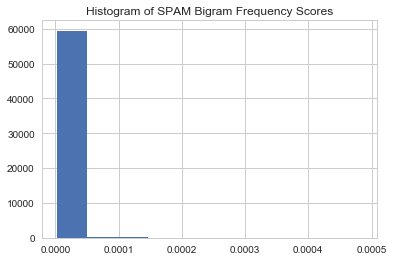

In [25]:
a = [s[1] for s in bigramSpamFreq]
plt.hist(a)
plt.title("Histogram of SPAM Bigram Frequency Scores")
plt.show()

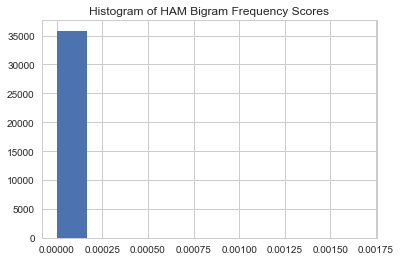

In [26]:
a = [s[1] for s in bigramHamFreq]
plt.hist(a)
plt.title("Histogram of HAM Bigram Frequency Scores")
plt.show()

### Typical Mutual Information Scores for SPAM and HAM bigrams

In [28]:
mean_score_mi_spam = np.mean([s[1] for s in bigramSpamMI])
median_score_mi_spam = np.median([s[1] for s in bigramSpamMI])
print("SPAM MI scores:\n")
print("Mean: {:.2E} Median: {:.2E}".format(mean_score_mi_spam, median_score_mi_spam))
mean_score_mi_ham = np.mean([s[1] for s in bigramHamMI])
median_score_mi_ham = np.median([s[1] for s in bigramHamMI])
print("\nHAM MI scores:\n")
print("Mean: {:.2E} Median: {:.2E}".format(mean_score_mi_ham, median_score_mi_ham))

SPAM MI scores:

Mean: 1.04E+01 Median: 1.03E+01

HAM MI scores:

Mean: 8.56E+00 Median: 8.46E+00


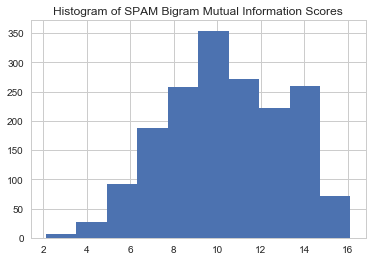

In [27]:
a = [s[1] for s in bigramSpamMI]
plt.hist(a)
plt.title("Histogram of SPAM Bigram Mutual Information Scores")
plt.show()

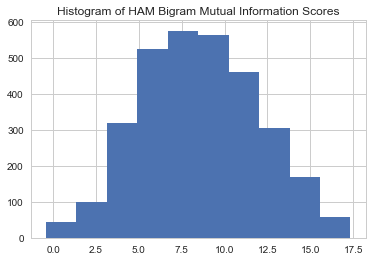

In [29]:
a = [s[1] for s in bigramHamMI]
plt.hist(a)
plt.title("Histogram of HAM Bigram Mutual Information Scores")
plt.show()

Observations:
* *Bigrams for SPAM exhibited more references to retail product entities, references to selling, and non-English phrases.*
* *Bigrams for HAM exhibited more repeated references to organization, person, and location entities.*
* *Bigrams for SPAM were on average more frequent than HAM by a small order of magnitude; the same could be said based on mutual information scores.*
* *Frequency scores exhibit a right-skewed distribution, whereas mutual information scores feature a more normal distribution.*

Actions:
* *Complete lists of bigrams were extracted for modeling and feature engineering.*


## Part-of-Speech Tag Frequencies for SPAM
* assess for nouns, verbs, adjectives, and adverbs

In [30]:
# function to print normalized frequencies of POS tags
# param documents: a list of tuples where the first item of each tuple is the tokenized email text
# prints normalized frequencies for nouns, verbs, adjectives, and adverbs
def getPosStats(documents):
    docs = documents
    # get list of tags
    pos = [t[1] for t in nltk.pos_tag(docs)]
    # aggregate class counts
    noun_count, verb_count, adj_count, adv_count = 0, 0, 0, 0
    for tag in pos:
        if tag.startswith('N'): noun_count += 1
        if tag.startswith('V'): verb_count += 1
        if tag.startswith('J'): adj_count += 1
        if tag.startswith('R'): adv_count += 1
    # normalize class counts
    noun_count_norm = noun_count / len(pos); print("Normalized Noun Frequency: {:.2f}".format(noun_count_norm))
    verb_count_norm = verb_count / len(pos); print("Normalized Verb Frequency: {:.2f}".format(verb_count_norm))
    adj_count_norm = adj_count / len(pos); print("Normalized Adjective Frequency: {:.2f}".format(adj_count_norm))
    adv_count_norm = adv_count / len(pos); print("Normalized Adverb Frequency: {:.2f}".format(adv_count_norm))    

In [31]:
%%time
getPosStats(spamTokens)   

Normalized Noun Frequency: 0.58
Normalized Verb Frequency: 0.15
Normalized Adjective Frequency: 0.20
Normalized Adverb Frequency: 0.03
Wall time: 10.1 s


## Part-of-Speech Tag Frequencies for HAM
* assess for nouns, verbs, adjectives, and adverbs

In [32]:
%%time
getPosStats(hamTokens)

Normalized Noun Frequency: 0.57
Normalized Verb Frequency: 0.19
Normalized Adjective Frequency: 0.18
Normalized Adverb Frequency: 0.03
Wall time: 17.9 s


Observations:
* At an aggregate level, both SPAM and HAM appear to be similar in their POS frequency distributions.
* SPAM tokens contain slightly more nouns and adjectives, and fewer verbs.

Actions:
* Include POS tag features in the modeling experimentation

# Modeling Experiments
* Feature Engineering
    * ngrams (bag of words)
        * unigrams - 
        * bigrams
    * word statistics (lexical richness/email, # characters/email, # words/email, mean # of characters per word)
    * POS tag features
* Modeling
    * NB NLTK
    * Multinomial NB Sci-kit Learn
    * SVM Sci-kit Learn
    * Logistic Regression Sci-kit Learn

### Combined list of tokenized documents

In [33]:
# combine labeled documents
print("There are {:d} SPAM documents and {:d} HAM documents".format(len(spamDocs), len(hamDocs)))
documents = spamDocs + hamDocs
print("There are a total of {:d} documents".format(len(documents)))

There are 1500 SPAM documents and 3672 HAM documents
There are a total of 5172 documents


### Randomly shuffle the documents for training and testing classifiers

In [34]:
random.seed(111)
random.shuffle(documents)
print([doc[1] for doc in documents[:20]]) # demonstrate labels have been shuffled

['spam', 'ham', 'ham', 'ham', 'spam', 'ham', 'ham', 'ham', 'ham', 'spam', 'ham', 'ham', 'spam', 'ham', 'ham', 'ham', 'ham', 'spam', 'ham', 'spam']


## Experiment 1: Testing the Application of Stopwords

The objective of this experiment is to test whether the application of an extensive stopwords list provides for improved classification results relative to a basic stopwords list from NLTK.

The extensive stopwords list contains 28056 words and includes:
* basic stopwords
* high-frequency words that are common to both classes
* hapaxes

Features: 3000 Unigrams
* Top 3000 words based on frequency varied by the stopwords applied

Classifier: Naive Bayes Classifier from NLTK

In [35]:
# function to get word features
# param documents: a list of tuples where the first item of each tuple is the tokenized email text
# param stopwords: a list of strings where each element is a stopword
# returns a list of 3000 strings where each string is a word feature
def getWordFeatures(documents, stopwords):    
    # lower-case conversion of complete document tokenization
    all_words_list = [word.lower() for (email, cat) in documents for word in email]
    # filter for alphabetic words
    all_words_list = [word for word in all_words_list if not alpha_filter(word)]
    # exclude stopwords
    keep_words = set(all_words_list) - set(stopwords)
    all_words_list = [word for word in all_words_list if word in keep_words]
    all_words = FreqDist(all_words_list)
    # get the 1500 most frequently appearing keywords in all words
    word_items = all_words.most_common(3000)
    word_features = [word for (word, count) in word_items]
    return word_features

# [feature definition function: experiment 1] function to get document features (applicable for unigrams)
# param document: a list of strings representing a tokenized email
# param word_features: a list of strings against which the tokens in document are matched
# returns a dictionary where each key is 'contains(keyword)' and is either true or false
def document_features(document, word_features):
    document_words = set(document)
    features = {}
    for word in word_features:
        features['V_{}'.format(word)] = (word in document_words)
    return features

# function to get feature sets for modeling in Experiment 1
def getFeatureSets1(documents, stopwords):
    # get word features based on specified stopwords
    word_features = getWordFeatures(documents, stopwords)
    featuresets = [(document_features(d, word_features), c) for (d, c) in documents]
    return featuresets

### Feature Extraction
* Two Unigram feature sets that either use basic or extensive stopwords lists
    * unigramBasic3000 uses 3000 word features having excluded basic stopwords (i.e. out-of-box NLTK)
    * unigramExt3000 uses 3000 word features having excluded extensive stopwords (i.e. basic stopwords, highly common keywords, hapaxes)

In [36]:
%%time
# get feature sets for documents using basic stopwords
unigramBasic3000 = getFeatureSets1(documents, stopwords1)
# split training and test sets 70/30
unigramBasic3000Train = unigramBasic3000[:3620]
unigramBasic3000Test = unigramBasic3000[3620:]

Wall time: 8.27 s


In [37]:
%%time
# get feature sets for documents using extensive stopwords
unigramExt3000 = getFeatureSets1(documents, stopwords2)
# split training and test sets 70/30
unigramExt3000Train = unigramExt3000[:3620]
unigramExt3000Test = unigramExt3000[3620:]

Wall time: 8.2 s


### Functions to Train Classifier with cross-validation: Naive Bayes Classifier in NLTK
### Compute Precision, Recall, F1 and Plot Confusion Matrix

In [38]:
# function to compute precision, recall, and f1 for each label and for any number of labels
# param gold: list of strings where each element is a gold label
# param predicted: list of strings where each element is a predicted label (in same order)
# output: prints precision, recall, f1 for each class
def eval_measures(gold, predicted):
    # get a list of labels
    labels = list(set(gold))
    # initialize list of class-specific scores
    precision_list, recall_list, f1_list = [],[],[]
    for lab in labels:
        # for each label, compare gold and predicted lists and compute values
        TP = FP = FN = TN = 0
        for i, val in enumerate(gold):
            if val == lab and predicted[i] == lab:  TP += 1
            if val == lab and predicted[i] != lab:  FN += 1
            if val != lab and predicted[i] == lab:  FP += 1
            if val != lab and predicted[i] != lab:  TN += 1
        # formulas for precision, recall, and f1
        precision = TP / (TP + FN)
        recall = TP / (TP + FP)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append( 2 * (recall * precision) / (recall + precision))
    # the evaluation measures in a table with one row per label
    print('class\tPrecision\tRecall\tF1\n')
    # print measures for each label
    for i, lab in enumerate(labels):
        print(lab, '\t', "{:10.3f}".format(precision_list[i]), \
          "{:10.3f}".format(recall_list[i]), "{:10.3f}".format(f1_list[i]))

# function to perform cross-validation and model evaluation for experiment 1
# param num_folds: integer specifying number of iterations
# param featuresets: list containing dictionary of features and label where each element is an email
# output: prints iteration accuracy and the mean accuracy
def cross_validation_accuracy(num_folds, featuresets):
    subset_size = int(len(featuresets)/num_folds)
    print('Each fold size:', subset_size, '\n')    
    accuracy_list = []
    # iterate over the folds
    for i in range(num_folds):
        test_this_round = featuresets[(i*subset_size):][:subset_size]
        train_this_round = featuresets[:(i*subset_size)] + featuresets[((i+1)*subset_size):]
        # train using train_this_round
        classifier = nltk.NaiveBayesClassifier.train(train_this_round)
        # evaluate against test_this_round and save accuracy
        accuracy_this_round = nltk.classify.accuracy(classifier, test_this_round)        
        print (i, 'accuracy:', accuracy_this_round)
        accuracy_list.append(accuracy_this_round)        
    # find mean accuracy over all rounds
    print ('mean accuracy', sum(accuracy_list) / num_folds)

# function to plot confusion matrix
# param gold: list of strings where each element is a gold label
# param predicted: list of strings where each element is a predicted label (in same order)
# output: plots confusion matrix with sklearn
def getCM(gold, predicted):
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(gold, predicted)
    # plot heatmap
    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    sns.heatmap(pd.DataFrame(cm), annot=True, cmap = "YlGnBu", fmt = 'g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

# function to produce precision, recall, f1, and confusion matrix
# param train: training set
# param test: test set
# output: prints precision, recall, f1, and plots a confusion matrix
def getClassScores(train, test):
    # train a classifier
    classifier = nltk.NaiveBayesClassifier.train(train)
    # get actuals and predictions
    goldlist, predictedlist = [],[]
    for (features, label) in test:
        goldlist.append(label)
        predictedlist.append(classifier.classify(features))
    # print evaluation measures
    eval_measures(goldlist, predictedlist)
    # plot confusion matrix
    getCM(goldlist, predictedlist)

### Model Evaluation: Basic Stopwords List

Each fold size: 724 

0 accuracy: 0.930939226519337
1 accuracy: 0.9337016574585635
2 accuracy: 0.9323204419889503
3 accuracy: 0.9157458563535912
4 accuracy: 0.9419889502762431
mean accuracy 0.930939226519337
class	Precision	Recall	F1

ham 	      0.948      0.953      0.951
spam 	      0.880      0.868      0.874
Wall time: 1min 39s


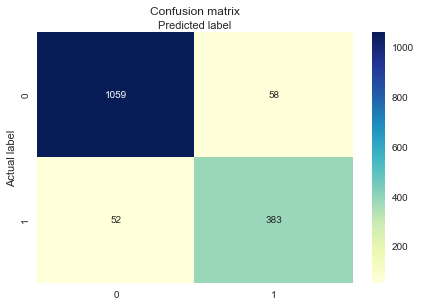

In [39]:
%%time
# 5-fold cross-validation on training set
cross_validation_accuracy(5, unigramBasic3000Train)
# train a classifier and predict test set; get evaluation metrics; plot confusion matrix
getClassScores(unigramBasic3000Train, unigramBasic3000Test)

### Model Evaluation: Extensive Stopwords List

Each fold size: 724 

0 accuracy: 0.9212707182320442
1 accuracy: 0.9116022099447514
2 accuracy: 0.919889502762431
3 accuracy: 0.9033149171270718
4 accuracy: 0.9433701657458563
mean accuracy 0.9198895027624309
class	Precision	Recall	F1

ham 	      0.951      0.929      0.940
spam 	      0.814      0.866      0.839
Wall time: 1min 40s


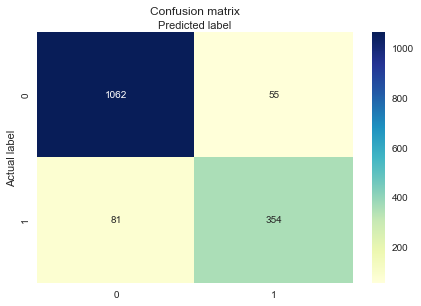

In [40]:
%%time
# 5-fold cross-validation on training set
cross_validation_accuracy(5, unigramExt3000Train)
# train a classifier and predict test set; get evaluation metrics; plot confusion matrix
getClassScores(unigramExt3000Train, unigramExt3000Test)

## Experiment 2: Testing the Effectiveness of Bigrams

The objective of this experiment is to test whether adding bigrams provides for improved classification results relative to just utilizing unigrams.

Baseline:
* Top 3000 unigrams by frequency with basic stopwords applied, as demonstrated in Experiment 1

Test:
* Top 3000 unigrams by frequency with basic stopwords exclusion
* Top 1000 bigrams scored by frequency with basic stopwords exclusion

Classifier: Naive Bayes Classifier from NLTK

In [41]:
# function to get bigram features
# param documents: a list of tuples where the first item of each tuple is the tokenized email text
# param stopwords: a list of strings where each element is a stopword
# returns a list of 1000 tuples where each element is a bigram feature
def getBigramFeatures(documents, stopwords):
    # lower-case conversionof complete document tokenization
    all_words_list = [word.lower() for (email, cat) in documents for word in email]
    # Top 1000 bigram feature extraction
    measures = BigramAssocMeasures()
    finder = BigramCollocationFinder.from_words(all_words_list) # scorer
    finder.apply_word_filter(alpha_filter) # exclude non-alphabetic words
    finder.apply_word_filter(lambda w: w in stopwords) # exclude stop words    
    scored = finder.score_ngrams(measures.raw_freq)
    bigram_features = [s[0] for s in scored[:1000]]
    return bigram_features


# [feature definition function: experiment 2] function to get document features (applicable for unigrams and bigrams)
# param document: a list of strings representing a tokenized email
# param word_features: a list of strings against which the tokens in document are matched
# returns a dictionary where each key is 'contains(keyword)' and is either true or false
def bigram_document_features(document, word_features, bigram_features):
    document_words = set(document)
    document_bigrams = nltk.bigrams(document)
    features = {}
    for word in word_features:
        features['V_{}'.format(word)] = (word in document_words)
    for bigram in bigram_features:
        features['B_{}_{}'.format(bigram[0], bigram[1])] = (bigram in document_bigrams)
    return features

# function to get feature sets for modeling in Experiment 2
def getFeatureSets2(documents, stopwords):
    # get word features based on specified stopwords
    word_features = getWordFeatures(documents, stopwords)
    # get bigram features based on specified stopwords
    bigram_features = getBigramFeatures(documents, stopwords)
    featuresets = [(bigram_document_features(d, word_features, bigram_features), c) for (d, c) in documents]
    return featuresets

### Feature Extraction
* Two feature sets that either use unigrams only or unigrams + bigrams
    * unigramBasic3000 uses 3000 word features having excluded basic stopwords (already extracted in Experiment 1)
    * bigramBasic4000 uses 3000 word features and 1000 bigram features having excluded basic stopwords

In [42]:
%%time
# get feature sets for documents using basic stopwords
bigramBasic4000 = getFeatureSets2(documents, stopwords1)
# split training and test sets 70/30
bigramBasic4000Train = bigramBasic4000[:3620]
bigramBasic4000Test = bigramBasic4000[3620:]

Wall time: 15 s


### Model Evaluation: Unigrams

Each fold size: 724 

0 accuracy: 0.930939226519337
1 accuracy: 0.9337016574585635
2 accuracy: 0.9323204419889503
3 accuracy: 0.9157458563535912
4 accuracy: 0.9419889502762431
mean accuracy 0.930939226519337
class	Precision	Recall	F1

ham 	      0.948      0.953      0.951
spam 	      0.880      0.868      0.874
Wall time: 1min 39s


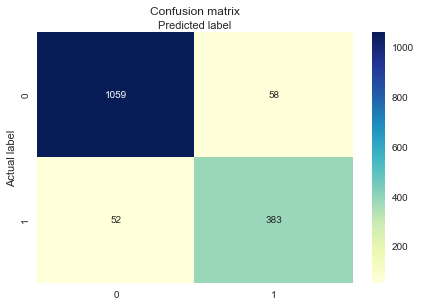

In [43]:
%%time
# 5-fold cross-validation on training set
cross_validation_accuracy(5, unigramBasic3000Train)
# train a classifier and predict test set; get evaluation metrics; plot confusion matrix
getClassScores(unigramBasic3000Train, unigramBasic3000Test)

### Model Evaluation: Unigrams + Bigrams

Each fold size: 724 

0 accuracy: 0.9323204419889503
1 accuracy: 0.9337016574585635
2 accuracy: 0.9323204419889503
3 accuracy: 0.9185082872928176
4 accuracy: 0.9419889502762431
mean accuracy 0.9317679558011049
class	Precision	Recall	F1

ham 	      0.947      0.960      0.954
spam 	      0.899      0.869      0.884
Wall time: 2min 15s


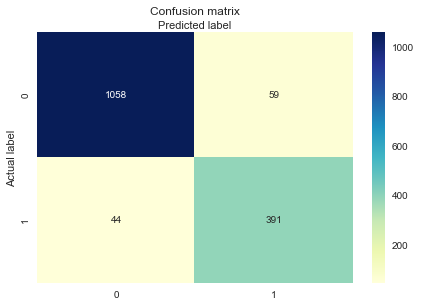

In [44]:
%%time
# 5-fold cross-validation on training set
cross_validation_accuracy(5, bigramBasic4000Train)
# train a classifier and predict test set: get evaluation metrics; plot confusion matrix
getClassScores(bigramBasic4000Train, bigramBasic4000Test)

## Experiment 3: Testing the Effectiveness of Part-of-Speech Tags

The objective of this experiment is to test whether adding POS tags provides for improved classification results relative to utilizing unigrams and bigrams. In earlier exploration of POS tag frequencies for SPAM and HAM documents, it was discovered that SPAM documents generally had higher frequencies of nouns and adjectives, and lower frequencies of verbs. This was gleaned at a corpus level, but this experiment will extract features at a document level to determine if they are useful for identifying SPAM.

Baseline:
* Top 3000 unigrams and top 1000 bigrams based on frequency with basic stopwords applied, as demonstrated in Experiment 2

Test:
* Top 3000 unigrams by frequency with basic stopwords exclusion
* Top 1000 bigrams scored by frequency with basic stopwords exclusion
* Normalized POS tag frequency (no stopwords removed) that aggregates for nouns, verbs, adjectives, and adverbs
    * The default NLTK (Stanford) tagger will be used
    * POS tags are known to be effective in certain circumstances such as with shorter sentence-level or social media posts (e.g. tweets)

Classifier: Naive Bayes Classifier from NLTK

In [ ]:
# function to get bigram features
# param documents: a list of tuples where the first item of each tuple is the tokenized email text
# param stopwords: a list of strings where each element is a stopword
# returns a list of 1000 tuples where each element is a bigram feature
def getBigramFeatures(documents, stopwords):
    # lower-case conversionof complete document tokenization
    all_words_list = [word.lower() for (email, cat) in documents for word in email]
    # Top 1000 bigram feature extraction
    measures = BigramAssocMeasures()
    finder = BigramCollocationFinder.from_words(all_words_list) # scorer
    finder.apply_word_filter(alpha_filter) # exclude non-alphabetic words
    finder.apply_word_filter(lambda w: w in stopwords) # exclude stop words    
    scored = finder.score_ngrams(measures.raw_freq)
    bigram_features = [s[0] for s in scored[:1000]]
    return bigram_features


# [feature definition function: experiment 2] function to get document features (applicable for unigrams and bigrams)
# param document: a list of strings representing a tokenized email
# param word_features: a list of strings against which the tokens in document are matched
# returns a dictionary where each key is 'contains(keyword)' and is either true or false
def bigram_document_features(document, word_features, bigram_features):
    document_words = set(document)
    document_bigrams = nltk.bigrams(document)
    features = {}
    for word in word_features:
        features['V_{}'.format(word)] = (word in document_words)
    for bigram in bigram_features:
        features['B_{}_{}'.format(bigram[0], bigram[1])] = (bigram in document_bigrams)
    return features

# function to get feature sets for modeling in Experiment 2
def getFeatureSets2(documents, stopwords):
    # get word features based on specified stopwords
    word_features = getWordFeatures(documents, stopwords)
    # get bigram features based on specified stopwords
    bigram_features = getBigramFeatures(documents, stopwords)
    featuresets = [(bigram_document_features(d, word_features, bigram_features), c) for (d, c) in documents]
    return featuresets

# Results

Experiment 1: Which Stopwords are Most Effective?
* *Two feature sets were created from unigrams that used either a basic stopwords list or an extensive stopwords list.*
* *The basic stopwords list only included the out-of-box English stopwords provided in NLTK. The extensive stopwords list included the same but also added high frequency words that were common to both SPAM and HAM, as well as hapaxes (highly infrequent words) for SPAM and HAM.*
* *A comparison of mean accuracies from cross-validation of the two unigram feature sets using the NLTK Naive Bayes Classifier show that using minimal stopwords improved mean accuracy by about 1 percentage points. The extensive stopwords list was not useful in improving classification accuracy.*
* *Mean accuracy was recorded at 92-93%. Class-specific precision, recall, and f1 shows that in all cases, the model is better at predicting HAM than SPAM. This is most likely due to the imbalanced data, where there are significantly more HAM observations than SPAM observations.*
* *Takeaway: Basic stopwords worked best in terms of model accuracy and overall performance (including speed)*

Experiment 2: Effect of Bigram Inclusion to the Featureset
* *In this experiment, two feature sets were compared based on classification accuracy and other evaluation measures. One feature set used unigrams exclusively to train a SPAM classifier, whereas the other used both unigrams and bigrams. Both feature sets applied basic stopwords during the feature extraction process*
* *Model evaluation based on the unigram feature set showed the same results as seen in Experiment 1 with an overall mean accuracy of about 93%. Precision, recall, and f1 specific to SPAM were 88%, 87%, and 87% respectively.*
* *Model evaluation based on the bigram feature set showed improved classification results with a slightly higher mean accuracy of about 93.2%. There were noticeable improvements in the precision, recall, and f1 specific to SPAM, which presents this model as a better SPAM classifier than the unigram-only model.*
* *Takeaway: Bigram features gave the model an added boost, particularly in predicting SPAM emails.*

# Conclusion

Lorum ipsum....